## Load libraries

In [1]:
library(tidyverse)
library(rasilabRtemplates)

theme_update(
  panel.border = element_rect(linetype = "solid", fill = NA, color = "gray", linewidth  = 1.2),
  axis.line.y = element_blank(),
  axis.line.x = element_blank(),
  axis.ticks = element_line(color = "gray"),
  axis.ticks.length = unit(0.1, "cm"),
  legend.key.size = unit(0.3, 'cm')
)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Load the data

In [2]:
## From Kaessmann 2019
lncs_file <- "../source_data/select_Kaessmann2019.csv"


## Supp table 5 from Posfai 2018
rna_seq_file <- "../source_data/S5_Table.csv"

In [3]:
## Import data
lncs <- read_csv(lncs_file) %>%
    janitor::clean_names() %>%
    rename(ensembl = ensembl75_id) %>%
    drop_na() %>%
    pull(ensembl) 

Rows: 182544 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ENSEMBL75 id, LncRNA name, Nearest coding gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
rna_seq <- read_csv(rna_seq_file) 

Rows: 196428 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): ensembl, gene, cell, timepoint
dbl (3): log2FC, pvalue, padj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Merge the data

In [9]:
## Merge data
data <- rna_seq %>%
    mutate(lncrna = ifelse(ensembl %in% lncs, TRUE, FALSE)) %>%
    mutate(timepoint = fct_relevel(timepoint, "early", "mid", "late")) %>%
    mutate(lncrna_sig = ifelse(lncrna == TRUE & padj < 0.05, TRUE, FALSE)) %>%
    # drop_na()
    write_csv("../tables/annotated_rna_seq.csv") 

## Make volcano plots

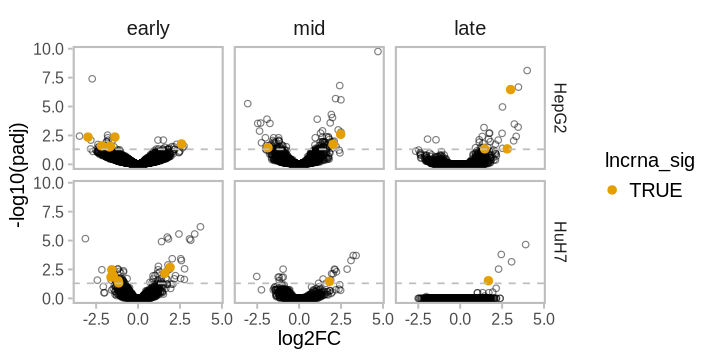

In [6]:
options(repr.plot.width = 6, repr.plot.height = 3)

ggplot(data, aes(x = log2FC, y = -log10(padj))) +
    geom_point(shape = 1, alpha = 0.5 ) +
    # add color to only sig genes
    geom_point(data = data %>% filter(lncrna_sig == TRUE), aes(color = lncrna_sig), size = 2) +
    # plot cutoff line
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "gray") +
    # change color of lncrna
    scale_color_manual(values = cbPalette[2:3]) +
    facet_grid(~cell ~ timepoint) +
    labs(x = "log2FC", y = "-log10(padj)") 

ggsave("../figures/volcano_plots.pdf", width = 6, height = 3, units = "in")

In [7]:
## Export the significant lncs
data %>%
    filter(lncrna_sig == TRUE) %>%
    select(ensembl) %>%
    write_csv("../tables/significant_lncs.csv")